This notebook will be dedicated towards generating a machine learning model that can predict an outbreak of malaria based on time.

The notebook will follow these steps:

1.) Upload malaria dataset: identify metric and year and select for Sudan and countries bordering Sudan

Define outbreak according to 2024 average https://www.who.int/data/gho/data/themes/malaria -- above of 60.4 cases per 1000 people is an outbreak

2.) Forecast NDVI and NDWI data back to beginning years of Malaria information, https://link.springer.com/article/10.1007/s10584-013-0851-z, this article links higher moisture and increased vegetation to the success of survival in mosquitoes.  Use the rainy and high vegetation seasons as information as a extra weight to malaria outbreak (must come up with a method for generating dataframes with different coefficients)

3.) Merge malaria outbreaks onto NDVI and NDWI based on year

4.) Preprocess data if necessary and test-train split them

5.) Run dataset through a logistic regression

6.) Maybe run through a neural network

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import skforecast

1.) Upload malaria dataset to come up with outbreaks in Sudan plus neighbors and prove their correlation with a heatmap

In [4]:
df_mal = pd.read_csv('Desktop/OMDENA_FINAL_DATASETS/malaria_cases.csv')

In [6]:
df_mal.head()

,IND_ID,IND_CODE,IND_UUID,IND_PER_CODE,DIM_TIME,DIM_TIME_TYPE,DIM_GEO_CODE_M49,DIM_GEO_CODE_TYPE,DIM_PUBLISH_STATE_CODE,IND_NAME,GEO_NAME_SHORT,RATE_PER_1000_N,RATE_PER_1000_NL,RATE_PER_1000_NU
0,442CEA8MALARIA_EST_INCIDENCE,MALARIA_EST_INCIDENCE,442CEA8,MALARIA_EST_INCIDENCE,2012,YEAR,9,REGION,PUBLISHED,Malaria cases,Oceania,148.12022,54.17984,293.38486
1,442CEA8MALARIA_EST_INCIDENCE,MALARIA_EST_INCIDENCE,442CEA8,MALARIA_EST_INCIDENCE,2011,YEAR,15,REGION,PUBLISHED,Malaria cases,Northern Africa,7.06374,5.22736,9.32541
2,442CEA8MALARIA_EST_INCIDENCE,MALARIA_EST_INCIDENCE,442CEA8,MALARIA_EST_INCIDENCE,2010,YEAR,18,REGION,PUBLISHED,Malaria cases,Southern Africa,1.53955,1.27314,1.98855
3,442CEA8MALARIA_EST_INCIDENCE,MALARIA_EST_INCIDENCE,442CEA8,MALARIA_EST_INCIDENCE,2005,YEAR,31,COUNTRY,PUBLISHED,Malaria cases,Azerbaijan,1.21551,1.21551,1.21551
4,442CEA8MALARIA_EST_INCIDENCE,MALARIA_EST_INCIDENCE,442CEA8,MALARIA_EST_INCIDENCE,2012,YEAR,800,COUNTRY,PUBLISHED,Malaria cases,Uganda,376.55597,296.59672,471.17035


In [8]:
df_mal.shape

(3588, 14)

Lets select for Sudan and the neighboring countries

In [11]:
countries = ['Sudan','Egypt','Chad','South Sudan','Eritrea','Central African Republic','Ethiopia']

In [13]:
df_mal_coun = df_mal[df_mal['GEO_NAME_SHORT'].isin(countries)]

In [15]:
df_mal_coun.shape

(161, 14)

In [17]:
df_mal_coun['DIM_TIME'].unique()

array([2020, 2019, 2005, 2001, 2011, 2007, 2009, 2013, 2010, 2017, 2018,
       2008, 2000, 2006, 2022, 2016, 2002, 2003, 2015, 2004, 2014, 2012,
       2021])

group by country to confirm we have all the countries and then group by year to see the spread of information

In [20]:
df_mal_coun.groupby('GEO_NAME_SHORT').sum()

,IND_ID,IND_CODE,IND_UUID,IND_PER_CODE,DIM_TIME,DIM_TIME_TYPE,DIM_GEO_CODE_M49,DIM_GEO_CODE_TYPE,DIM_PUBLISH_STATE_CODE,IND_NAME,RATE_PER_1000_N,RATE_PER_1000_NL,RATE_PER_1000_NU
GEO_NAME_SHORT,,,,,,,,,,,,,
Central African Republic,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442C...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,46253,YEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYE...,3220,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUN...,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,8872.56839,6096.34147,12545.07453
Chad,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442C...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,46253,YEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYE...,3404,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUN...,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,5211.45941,3283.83888,7906.19812
Egypt,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442C...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,46253,YEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYE...,18814,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUN...,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,0.00000,0.00000,0.00000
Eritrea,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442C...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,46253,YEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYE...,5336,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUN...,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,508.96552,303.30431,755.64098
Ethiopia,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442C...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,46253,YEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYE...,5313,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUN...,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,3726.08846,1530.33065,7765.71505
South Sudan,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442C...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,46253,YEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYE...,16744,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUN...,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,6699.54248,4740.16019,9260.51416
Sudan,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442C...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,46253,YEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYEARYE...,16767,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUN...,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,1253.20170,760.03654,1968.17518


In [22]:
df_mal_coun.groupby('DIM_TIME').sum()

,IND_ID,IND_CODE,IND_UUID,IND_PER_CODE,DIM_TIME_TYPE,DIM_GEO_CODE_M49,DIM_GEO_CODE_TYPE,DIM_PUBLISH_STATE_CODE,IND_NAME,GEO_NAME_SHORT,RATE_PER_1000_N,RATE_PER_1000_NL,RATE_PER_1000_NU
DIM_TIME,,,,,,,,,,,,,
2000,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,YEARYEARYEARYEARYEARYEARYEAR,3026,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRY,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,Central African RepublicEthiopiaEritreaChadEgy...,1475.87683,981.95796,2133.79525
2001,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,YEARYEARYEARYEARYEARYEARYEAR,3026,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRY,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,EritreaChadSouth SudanSudanCentral African Rep...,1447.09345,868.51543,2182.36887
2002,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,YEARYEARYEARYEARYEARYEARYEAR,3026,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRY,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,EthiopiaCentral African RepublicSudanChadSouth...,1352.54779,826.43438,2027.72680
2003,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,YEARYEARYEARYEARYEARYEARYEAR,3026,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRY,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,ChadEgyptSouth SudanEritreaCentral African Rep...,1346.75963,825.58311,2033.89233
2004,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,YEARYEARYEARYEARYEARYEARYEAR,3026,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRY,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,South SudanSudanCentral African RepublicEgyptE...,1297.81438,817.29513,2157.18081
2005,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,YEARYEARYEARYEARYEARYEARYEAR,3026,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRY,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,SudanSouth SudanCentral African RepublicEthiop...,1220.56320,791.91486,1944.64642
2006,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,YEARYEARYEARYEARYEARYEARYEAR,3026,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRY,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,ChadCentral African RepublicEritreaEgyptSouth ...,1191.61276,796.96007,1867.98116
2007,442CEA8MALARIA_EST_INCIDENCE442CEA8MALARIA_EST...,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8442CEA8,MALARIA_EST_INCIDENCEMALARIA_EST_INCIDENCEMALA...,YEARYEARYEARYEARYEARYEARYEAR,3026,COUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRYCOUNTRY,PUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDPUBLISHEDP...,Malaria casesMalaria casesMalaria casesMalaria...,South SudanEgyptEritreaChadCentral African Rep...,1143.07156,786.77600,1722.10455
2008,442CEA8MALARIA_EST_I

In [24]:
df_melt = pd.melt(df_mal_coun, id_vars=['GEO_NAME_SHORT','DIM_TIME'], value_vars='RATE_PER_1000_N')

In [26]:
df_melt.head()

,GEO_NAME_SHORT,DIM_TIME,variable,value
0,South Sudan,2020,RATE_PER_1000_N,283.13122
1,Egypt,2019,RATE_PER_1000_N,0.00000
2,Sudan,2005,RATE_PER_1000_N,54.65162
3,Eritrea,2001,RATE_PER_1000_N,22.12129
4,Central African Republic,2011,RATE_PER_1000_N,394.23485


In [28]:
df_melt = df_melt.sort_values(['GEO_NAME_SHORT','DIM_TIME'])

In [30]:
df_melt = df_melt.reset_index(drop=True)

In [32]:
df_melt.head(20)

,GEO_NAME_SHORT,DIM_TIME,variable,value
0,Central African Republic,2000,RATE_PER_1000_N,424.43784
1,Central African Republic,2001,RATE_PER_1000_N,425.44202
2,Central African Republic,2002,RATE_PER_1000_N,433.17590
3,Central African Republic,2003,RATE_PER_1000_N,438.45362
4,Central African Republic,2004,RATE_PER_1000_N,442.38589
5,Central African Republic,2005,RATE_PER_1000_N,444.16149
6,Central African Republic,2006,RATE_PER_1000_N,444.52947
7,Central African Republic,2007,RATE_PER_1000_N,437.35866
8,Central African Republic,2008,RATE_PER_1000_N,427.61325
9,Central African Republic,2009,RATE_PER_1000_N,418.69170


In [34]:
def country_plotter(df, countries):
    
    for i in countries:
        x = []
        y = []
        
        for j in range(len(df)):
            if df.loc[j,'GEO_NAME_SHORT'] == i:
                x.append(df.loc[j, 'DIM_TIME'])
                y.append(df.loc[j, 'value'])

        plt.plot(x, y)
        plt.xlabel('year')
        plt.ylabel('incidents of malaria per 1000 people')
        
                

        

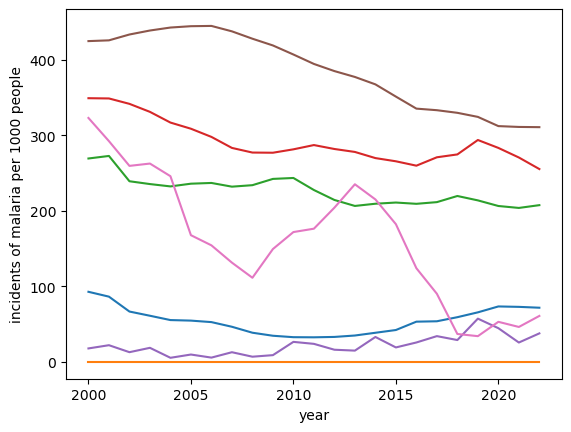

In [36]:
country_mal_plot = country_plotter(df_melt, countries)

There are three countries that correlate closely, lets see if one of them is Sudan

In [197]:
def country_correlation(df, countries):
    countries_stor = {}
    for i in countries:
        #x = []
        y = []
        
        for j in range(len(df)):
            if df.loc[j,'GEO_NAME_SHORT'] == i:
                #x.append(df.loc[j, 'DIM_TIME'])
                y.append(df.loc[j, 'value'])

        countries_stor[i] = y

    y_list = [v for k,v in countries_stor.items()]

    y_list_len = len(y_list)

    #start printing the correlations between malaria incidents

    for a in range(y_list_len):

        for b in range(y_list_len):

            if a == b:
                continue

            else:
                corr = np.correlate(y_list[a], y_list[b])
                if countries[a] == 'Sudan':
                    print (f'correlation between {countries[a]} and {countries[b]} is {corr}')

        


    

In [199]:
correlation = country_correlation(df_melt, countries)

KeyError: 46

Sudan correlates positively with central african republic, south sudan, eritrea, chad, and ethiopia, so we can use those in the dataframe as neighboring vectors for malaria

In [44]:
df_melt = df_melt[df_melt['GEO_NAME_SHORT'] != 'Egypt']

In [46]:
df_melt.head()

,GEO_NAME_SHORT,DIM_TIME,variable,value
0,Central African Republic,2000,RATE_PER_1000_N,424.43784
1,Central African Republic,2001,RATE_PER_1000_N,425.44202
2,Central African Republic,2002,RATE_PER_1000_N,433.17590
3,Central African Republic,2003,RATE_PER_1000_N,438.45362
4,Central African Republic,2004,RATE_PER_1000_N,442.38589


In [48]:
almost_final_df = df_melt.drop(columns='variable')

In [50]:
almost_final_df = almost_final_df.rename(columns={'value':'Incidence_per_1000_people'})

In [52]:
almost_final_df.head()

,GEO_NAME_SHORT,DIM_TIME,Incidence_per_1000_people
0,Central African Republic,2000,424.43784
1,Central African Republic,2001,425.44202
2,Central African Republic,2002,433.17590
3,Central African Republic,2003,438.45362
4,Central African Republic,2004,442.38589


In [54]:
almost_final_df.shape

(138, 3)

In [56]:
almost_final_df= almost_final_df.reset_index(drop=True)

We have 23 years for six countries, lets start defining outbreak per the threshold of 60.4 cases

In [59]:
def outbreak_label(df):

    out_list = []

    for i in range(len(df)):
        if df.loc[i,'Incidence_per_1000_people'] >= 60.4:
            out_list.append(1)

        else:
            out_list.append(0)

    out_frame = pd.DataFrame({'outbreak':out_list})


    return out_frame
        

In [61]:
outbreak_frame = outbreak_label(almost_final_df)

In [63]:
print (outbreak_frame)

     outbreak
0           1
1           1
2           1
3           1
4           1
..        ...
133         0
134         1
135         1
136         1
137         1

[138 rows x 1 columns]


In [66]:
final_outbreak_df = pd.concat([almost_final_df, outbreak_frame], axis=1)

In [68]:
final_outbreak_df.tail()

,GEO_NAME_SHORT,DIM_TIME,Incidence_per_1000_people,outbreak
133,Sudan,2018,59.18903,0
134,Sudan,2019,65.59086,1
135,Sudan,2020,73.39838,1
136,Sudan,2021,72.84448,1
137,Sudan,2022,71.71054,1


In [70]:
final_outbreak_df.groupby('GEO_NAME_SHORT').sum()

,DIM_TIME,Incidence_per_1000_people,outbreak
GEO_NAME_SHORT,,,
Central African Republic,46253,8872.56839,23
Chad,46253,5211.45941,23
Eritrea,46253,508.96552,0
Ethiopia,46253,3726.08846,19
South Sudan,46253,6699.54248,23
Sudan,46253,1253.20170,8


Looks like Sudan is actually doing pretty good compared to its neighbors as far as outbreaks go

2.) Merge malaria cases with Sudan's NDWI and NVDI after its been forecasted backwards

In [74]:
import skforecast
from skforecast import model_selection

import pmdarima as pm
import sklearn
from sklearn import tree


In [76]:
ndvi_df = pd.read_csv('Desktop/OMDENA_FINAL_DATASETS/final_ndvi_geographic.csv')

In [78]:
ndvi_df.head()

,date,value,state
0,2015-10-20,0.005310,AlJazirah
1,2015-11-29,0.017227,AlJazirah
2,2015-12-09,0.058856,AlJazirah
3,2015-12-19,0.030519,AlJazirah
4,2015-12-29,0.084125,AlJazirah


Lets choose Khartoum as representative for the Country since the EDA showed the patterns were very similar across the entier country

In [81]:
ndvi_sub1 = ndvi_df[ndvi_df['state'] == 'Khartoum']

In [83]:
ndvi_sub2 = ndvi_sub1[['date','value']]

In [85]:
ndvi_sub1.head()

,date,value,state
48519,2015-10-20,0.005310,Khartoum
48520,2015-11-29,0.017227,Khartoum
48521,2015-12-09,0.058856,Khartoum
48522,2015-12-19,0.030519,Khartoum
48523,2015-12-29,0.084125,Khartoum


In [87]:
ndvi_sub2.head()

,date,value
48519,2015-10-20,0.005310
48520,2015-11-29,0.017227
48521,2015-12-09,0.058856
48522,2015-12-19,0.030519
48523,2015-12-29,0.084125


In [89]:
ndvi_sub2.index

Index([48519, 48520, 48521, 48522, 48523, 48524, 48525, 48526, 48527, 48528,
       ...
       55697, 55698, 55699, 55700, 55701, 55702, 55703, 55704, 55705, 55706],
      dtype='int64', length=7188)

In [91]:
ndvi_sub2.shape

(7188, 2)

In [93]:
ndvi_sub2.dtypes

date      object
value    float64
dtype: object

Since there is no outbreak information on 2023 and 2024, lets use that year for the test dataset

In [96]:
train_start = '2015-10-20'
train_end = '2022-12-31'

test_start = '2023-01-01'
test_end = '2024-12-31'

In [100]:
ndvi_sub2 = ndvi_sub2.rename(columns= {'date':'ds','value':'y'})

In [102]:
ndvi_sub2 = ndvi_sub2.sort_values(by='ds', axis=0)

In [104]:
ndvi_sub2 = ndvi_sub2.reset_index(drop=True)

In [106]:
ndvi_sub2.shape

(7188, 2)

In [108]:
ndvi_sub2.head(10)

,ds,y
0,2015-10-20,0.00531
1,2015-10-20,0.00531
2,2015-10-20,0.00531
3,2015-10-20,0.00531
4,2015-10-20,0.00531
5,2015-10-20,0.00531
6,2015-10-20,0.00531
7,2015-10-20,0.00531
8,2015-10-20,0.00531
9,2015-10-20,0.00531


In [110]:
ndvi_sub2 = ndvi_sub2.drop_duplicates(keep='first')

In [112]:
ndvi_sub2.shape

(599, 2)

In [122]:
print (round(599*.8))

479


In [116]:
print (599-479)

120


In [284]:
ndvi_sub2.head()

,ds,y
0,2015-10-20,0.005310
12,2015-11-29,0.017227
24,2015-12-09,0.058856
36,2015-12-19,0.030519
48,2015-12-29,0.084125


In [124]:
from prophet import Prophet
import numpy as np

In [126]:
ndvi_sub2.head()

,ds,y
0,2015-10-20,0.005310
12,2015-11-29,0.017227
24,2015-12-09,0.058856
36,2015-12-19,0.030519
48,2015-12-29,0.084125


In [128]:
train_df = ndvi_sub2.iloc[0:479]

In [130]:
train_df.tail()

,ds,y
5688,2023-04-11,0.036651
5700,2023-04-16,0.032657
5712,2023-04-21,0.016180
5724,2023-04-26,0.762431
5736,2023-05-01,0.007485


In [132]:
m = Prophet()
m.fit(train_df)

12:52:17 - cmdstanpy - INFO - Chain [1] start processing
12:52:17 - cmdstanpy - INFO - Chain [1] done processing


In [134]:
print (365+240)

605


In [136]:
future = m.make_future_dataframe(periods=605)
future.tail()

,ds
1079,2024-12-22
1080,2024-12-23
1081,2024-12-24
1082,2024-12-25
1083,2024-12-26


In [138]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1079,2024-12-22,0.077359,-0.104256,0.254747
1080,2024-12-23,0.099076,-0.096714,0.291635
1081,2024-12-24,0.111759,-0.068443,0.290505
1082,2024-12-25,0.076289,-0.110841,0.273272
1083,2024-12-26,0.041083,-0.149572,0.228415


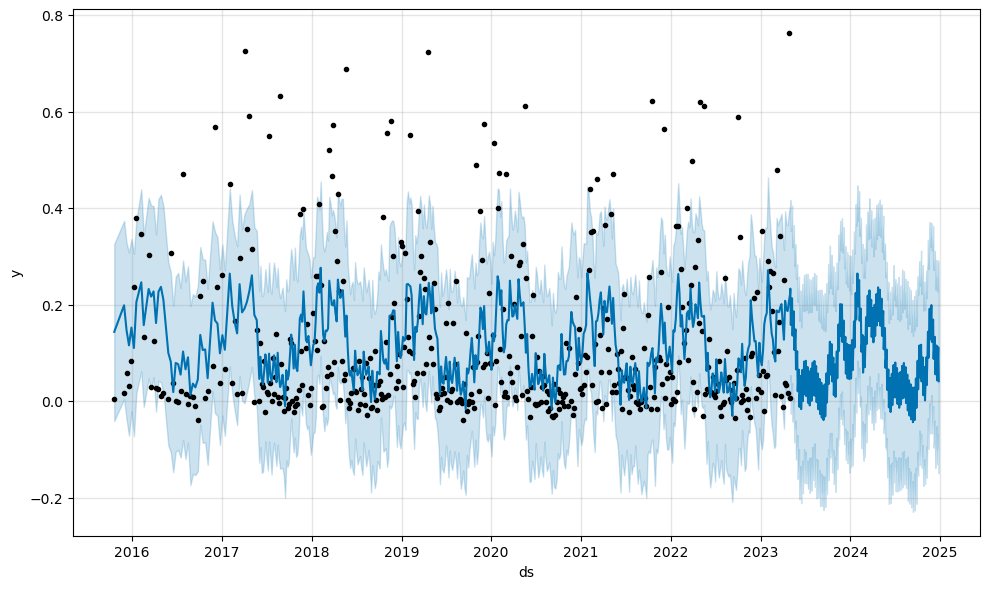

In [140]:
fig1 = m.plot(forecast)

In [142]:
past = pd.DataFrame(data = {})

In [144]:
from datetime import date, timedelta

start_dt = date(2000, 1, 1)
end_dt = date(2015, 10, 19)

# difference between current and previous date
delta = timedelta(days=1)

# store the dates between two dates in a list
dates = []

while start_dt <= end_dt:
    # add current date to list by converting  it to iso format
    dates.append(start_dt.isoformat())
    # increment start date by timedelta
    start_dt += delta

print('Dates between', start_dt, 'and', end_dt)


Dates between 2015-10-20 and 2015-10-19


In [146]:
past_dates = pd.DataFrame(data = {'ds':dates+ [x for x in ndvi_sub2['ds']]})

In [148]:
past_dates.head()

,ds
0,2000-01-01
1,2000-01-02
2,2000-01-03
3,2000-01-04
4,2000-01-05


In [150]:
forecast_past = m.predict(past_dates)

In [152]:
forecast_past[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6365,2024-12-11,0.094108,-0.089576,0.283371
6366,2024-12-16,0.103781,-0.068062,0.292626
6367,2024-12-21,0.072798,-0.116552,0.257362
6368,2024-12-26,0.041083,-0.146546,0.221766
6369,2024-12-31,0.111122,-0.090509,0.280577


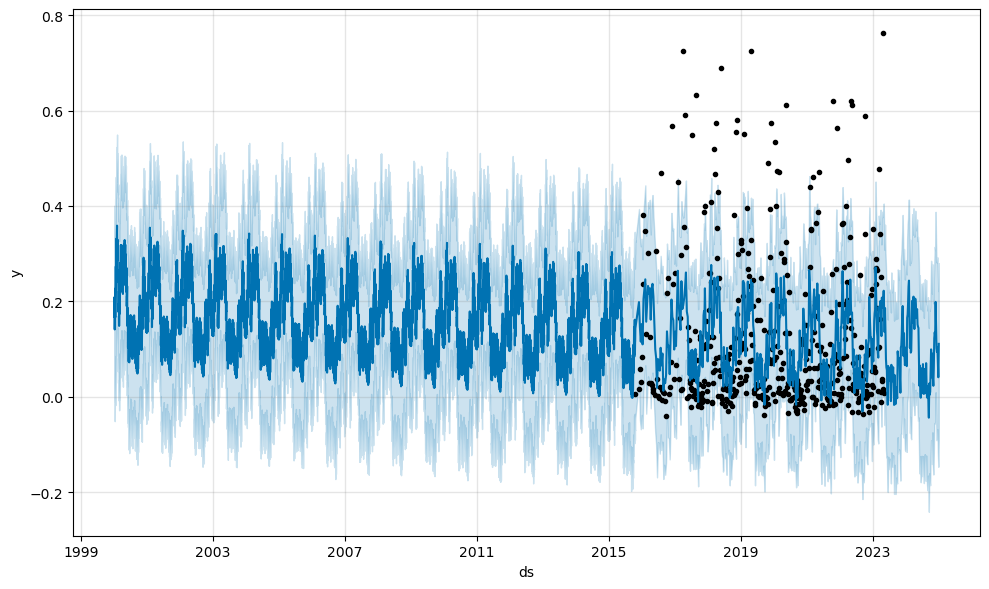

In [154]:
fig2 = m.plot(forecast_past)

Now lets repeat the process for the ndwi data

In [394]:
ndwi_df = pd.read_csv('Desktop/OMDENA_FINAL_DATASETS/final_ndwi_geographic.csv')

In [396]:
ndwi_df.head()

,date,value,state
0,2015-10-20,-0.011545,AlJazirah
1,2015-11-29,-0.040840,AlJazirah
2,2015-12-09,-0.094806,AlJazirah
3,2015-12-19,0.015846,AlJazirah
4,2015-12-29,-0.074044,AlJazirah


In [398]:
ndwi_sub1 = ndwi_df[ndvi_df['state'] == 'Khartoum']

In [400]:
ndwi_sub2 = ndwi_sub1[['date','value']]

In [402]:
ndwi_sub2 = ndwi_sub2.rename(columns= {'date':'ds','value':'y'})

In [404]:
ndwi_sub2 = ndwi_sub2.drop_duplicates(keep='first')

In [406]:
ndwi_sub2 = ndwi_sub2.sort_values(by='ds', axis=0)

In [408]:
ndwi_sub2.shape

(599, 2)

In [410]:
ndwi_sub2.head()

,ds,y
48519,2015-10-20,-0.011545
48520,2015-11-29,-0.040840
48521,2015-12-09,-0.094806
48522,2015-12-19,0.015846
48523,2015-12-29,-0.074044


In [412]:
m_wi = Prophet()
m_wi.fit(ndwi_sub2)

13:58:29 - cmdstanpy - INFO - Chain [1] start processing
13:58:29 - cmdstanpy - INFO - Chain [1] done processing


In [414]:
from datetime import date, timedelta

start_dt = date(2000, 1, 1)
end_dt = date(2015, 10, 19)

# difference between current and previous date
delta = timedelta(days=1)

# store the dates between two dates in a list
dates_wi = []

while start_dt <= end_dt:
    # add current date to list by converting  it to iso format
    dates_wi.append(start_dt.isoformat())
    # increment start date by timedelta
    start_dt += delta

print('Dates between', start_dt, 'and', end_dt)

Dates between 2015-10-20 and 2015-10-19


In [416]:
past_dates_wi = pd.DataFrame(data = {'ds':dates+ [x for x in ndwi_sub2['ds']]})

In [418]:
past_dates_wi.head()

,ds
0,2000-01-01
1,2000-01-02
2,2000-01-03
3,2000-01-04
4,2000-01-05


In [420]:
forecast_past_wi = m_wi.predict(past_dates_wi)

In [422]:
forecast_past_wi.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,-0.098043,-0.226620,0.050582,-0.098043,-0.098043,0.020363,0.020363,0.020363,-0.001444,-0.001444,-0.001444,0.021806,0.021806,0.021806,0.0,0.0,0.0,-0.077680
1,2000-01-02,-0.098044,-0.214730,0.062342,-0.098044,-0.098044,0.021327,0.021327,0.021327,0.000110,0.000110,0.000110,0.021217,0.021217,0.021217,0.0,0.0,0.0,-0.076718
2,2000-01-03,-0.098046,-0.218996,0.056249,-0.098046,-0.098046,0.011796,0.011796,0.011796,-0.008591,-0.008591,-0.008591,0.020387,0.020387,0.020387,0.0,0.0,0.0,-0.086250
3,2000-01-04,-0.098048,-0.233287,0.044345,-0.098048,-0.098048,0.001317,0.001317,0.001317,-0.017983,-0.017983,-0.017983,0.019300,0.019300,0.019300,0.0,0.0,0.0,-0.096731
4,2000-01-05,-0.098049,-0.231144,0.040391,-0.098049,-0.098049,0.009661,0.009661,0.009661,-0.008278,-0.008278,-0.008278,0.017938,0.017938,0.017938,0.0,0.0,0.0,-0.088389


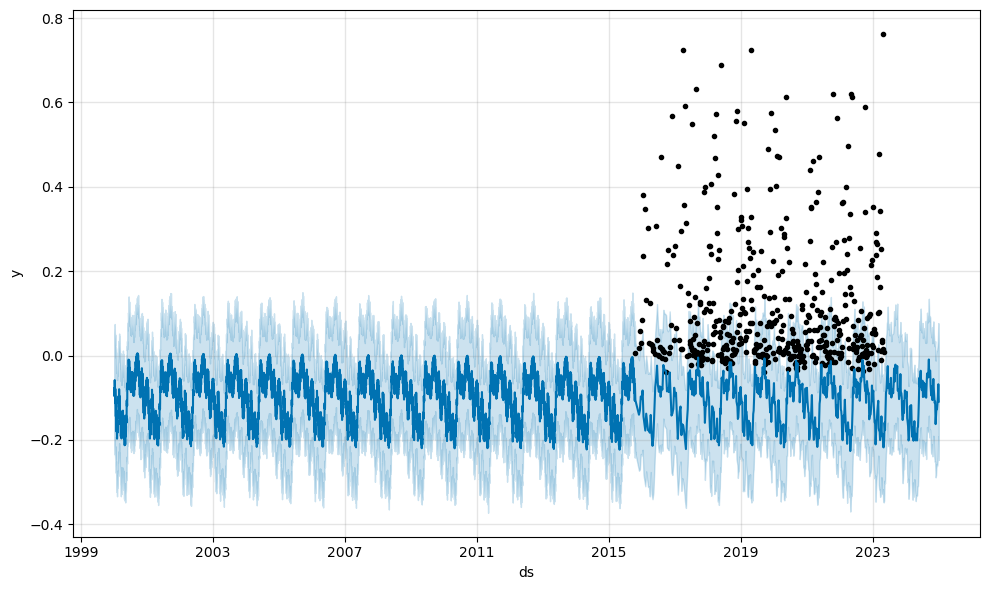

In [424]:
fig3 = m.plot(forecast_past_wi)

So it looks like the time series are fairly accurate with pattern within the data points provided in the original dataset


It is time to combine the time series dataframes with the malaria information

NDVI DF from 2000 -2024

In [429]:
forecast_past.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,0.189908,-0.007112,0.360412,0.189908,0.189908,-0.021630,-0.021630,-0.021630,-0.004821,-0.004821,-0.004821,-0.016808,-0.016808,-0.016808,0.0,0.0,0.0,0.168279
1,2000-01-02,0.189899,-0.008879,0.350794,0.189899,0.189899,-0.016550,-0.016550,-0.016550,0.000026,0.000026,0.000026,-0.016575,-0.016575,-0.016575,0.0,0.0,0.0,0.173349
2,2000-01-03,0.189889,0.012193,0.364632,0.189889,0.189889,0.005812,0.005812,0.005812,0.021947,0.021947,0.021947,-0.016135,-0.016135,-0.016135,0.0,0.0,0.0,0.195701
3,2000-01-04,0.189880,0.027241,0.400913,0.189880,0.189880,0.019362,0.019362,0.019362,0.034788,0.034788,0.034788,-0.015426,-0.015426,-0.015426,0.0,0.0,0.0,0.209242
4,2000-01-05,0.189870,-0.000370,0.366578,0.189870,0.189870,-0.014929,-0.014929,-0.014929,-0.000546,-0.000546,-0.000546,-0.014383,-0.014383,-0.014383,0.0,0.0,0.0,0.174941


NDWI DF from 2000 -2024

In [432]:
forecast_past_wi.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,-0.098043,-0.226620,0.050582,-0.098043,-0.098043,0.020363,0.020363,0.020363,-0.001444,-0.001444,-0.001444,0.021806,0.021806,0.021806,0.0,0.0,0.0,-0.077680
1,2000-01-02,-0.098044,-0.214730,0.062342,-0.098044,-0.098044,0.021327,0.021327,0.021327,0.000110,0.000110,0.000110,0.021217,0.021217,0.021217,0.0,0.0,0.0,-0.076718
2,2000-01-03,-0.098046,-0.218996,0.056249,-0.098046,-0.098046,0.011796,0.011796,0.011796,-0.008591,-0.008591,-0.008591,0.020387,0.020387,0.020387,0.0,0.0,0.0,-0.086250
3,2000-01-04,-0.098048,-0.233287,0.044345,-0.098048,-0.098048,0.001317,0.001317,0.001317,-0.017983,-0.017983,-0.017983,0.019300,0.019300,0.019300,0.0,0.0,0.0,-0.096731
4,2000-01-05,-0.098049,-0.231144,0.040391,-0.098049,-0.098049,0.009661,0.009661,0.009661,-0.008278,-0.008278,-0.008278,0.017938,0.017938,0.017938,0.0,0.0,0.0,-0.088389


Malaria Cases

In [201]:
final_outbreak_df.head()

,GEO_NAME_SHORT,DIM_TIME,Incidence_per_1000_people,outbreak
0,Central African Republic,2000,424.43784,1
1,Central African Republic,2001,425.44202,1
2,Central African Republic,2002,433.17590,1
3,Central African Republic,2003,438.45362,1
4,Central African Republic,2004,442.38589,1


In [203]:
malaria_sudan = final_outbreak_df[final_outbreak_df['GEO_NAME_SHORT'] == 'Sudan']

In [205]:
malaria_sudan.head()

,GEO_NAME_SHORT,DIM_TIME,Incidence_per_1000_people,outbreak
115,Sudan,2000,92.77145,1
116,Sudan,2001,86.35270,1
117,Sudan,2002,66.65404,1
118,Sudan,2003,61.08878,1
119,Sudan,2004,55.37405,0


Lets group the ndvi and ndwi values by histograms so we can create a term that is multiplied by the incidence per 1000 people and used to separate the values accordingly

NDVI values histogram

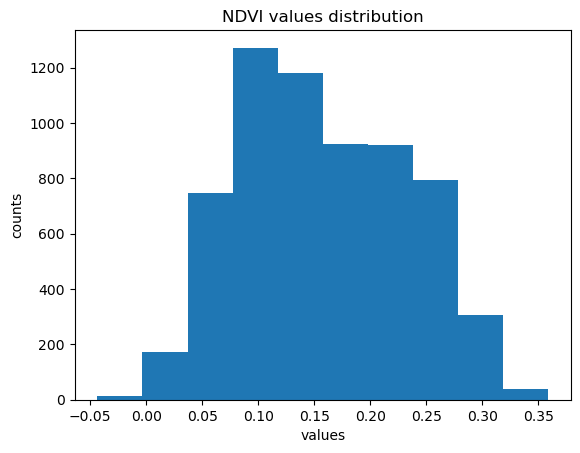

In [434]:
plt.hist(forecast_past['yhat'])
plt.xlabel('values')
plt.ylabel('counts')
plt.title('NDVI values distribution')
plt.show()

NDWI Values histogram

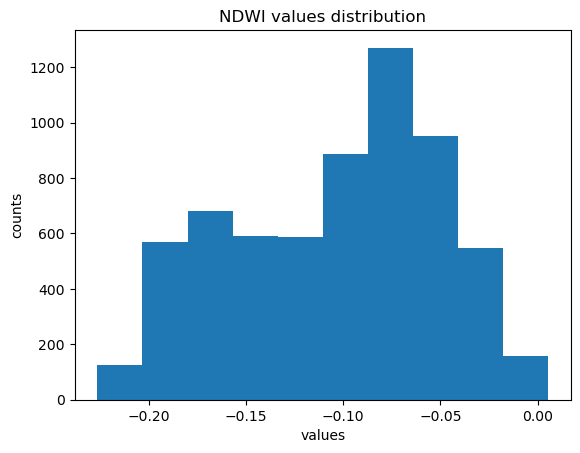

In [437]:
plt.hist(forecast_past_wi['yhat'])
plt.xlabel('values')
plt.ylabel('counts')
plt.title('NDWI values distribution')
plt.show()

group ndvi values by month and then turn ndvi values into probabilites and then multiply by the malaria outbreak or not number 

In [440]:
ndvi_past = forecast_past[['ds','yhat']]

In [442]:
ndvi_past.head()

,ds,yhat
0,2000-01-01,0.168279
1,2000-01-02,0.173349
2,2000-01-03,0.195701
3,2000-01-04,0.209242
4,2000-01-05,0.174941


In [444]:
ndvi_past['ds'] = pd.to_datetime(ndvi_past['ds'])

/var/folders/w4/swg_x0mn7sl_p9j90gy4tmk80000gn/T/ipykernel_4424/631648079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndvi_past['ds'] = pd.to_datetime(ndvi_past['ds'])


In [446]:
ndvi_past.head()

,ds,yhat
0,2000-01-01,0.168279
1,2000-01-02,0.173349
2,2000-01-03,0.195701
3,2000-01-04,0.209242
4,2000-01-05,0.174941


In [448]:
ndvi_past.dtypes

ds      datetime64[ns]
yhat           float64
dtype: object

In [450]:
ndvi_past['year'] = [x.year for x in ndvi_past.ds]

/var/folders/w4/swg_x0mn7sl_p9j90gy4tmk80000gn/T/ipykernel_4424/198580618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndvi_past['year'] = [x.year for x in ndvi_past.ds]


In [452]:
ndvi_past['month'] = [x.month for x in ndvi_past.ds]

/var/folders/w4/swg_x0mn7sl_p9j90gy4tmk80000gn/T/ipykernel_4424/3682346688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndvi_past['month'] = [x.month for x in ndvi_past.ds]


In [454]:
ndvi_grouped = ndvi_past.groupby(['year','month']).mean()

In [456]:
ndvi_grouped = ndvi_grouped.reset_index(drop=True)

In [458]:
ndvi_grouped.head()

,ds,yhat
0,2000-01-16 00:00:00,0.235647
1,2000-02-15 00:00:00,0.244253
2,2000-03-16 00:00:00,0.260583
3,2000-04-15 12:00:00,0.273934
4,2000-05-16 00:00:00,0.229697


In [460]:
ndvi_grouped['year'] = [x.year for x in ndvi_grouped.ds]

In [462]:
ndvi_grouped['month'] = [x.month for x in ndvi_grouped.ds]

In [464]:
ndvi_grouped.head()

,ds,yhat,year,month
0,2000-01-16 00:00:00,0.235647,2000,1
1,2000-02-15 00:00:00,0.244253,2000,2
2,2000-03-16 00:00:00,0.260583,2000,3
3,2000-04-15 12:00:00,0.273934,2000,4
4,2000-05-16 00:00:00,0.229697,2000,5


In [468]:
from sklearn.preprocessing import StandardScaler

### fix this next time you see this

In [573]:
def prob_max_func(df, col):

    prob_list = []

    for x in df[col]:

        prob_list.append(x)


    min_val = min(prob_list)

    min_added = [x+abs(min_val) for x in prob_list]

    max_val = max(min_added)

    norm = [x/max_val for x in min_added]

    df['prob'] = norm


    return df

    

In [684]:
ndvi_prob = prob_max_func(ndvi_grouped, 'yhat')

In [686]:
ndvi_prob.head()

,ds,yhat,year,month,prob
0,2000-01-16 00:00:00,0.235647,2000,1,0.861015
1,2000-02-15 00:00:00,0.244253,2000,2,0.892254
2,2000-03-16 00:00:00,0.260583,2000,3,0.951534
3,2000-04-15 12:00:00,0.273934,2000,4,1.000000
4,2000-05-16 00:00:00,0.229697,2000,5,0.839416


Now ndwi

In [580]:
ndwi_past = forecast_past_wi[['ds','yhat']]

In [582]:
ndwi_past.head()

,ds,yhat
0,2000-01-01,-0.077680
1,2000-01-02,-0.076718
2,2000-01-03,-0.086250
3,2000-01-04,-0.096731
4,2000-01-05,-0.088389


In [584]:
ndwi_past['ds'] = pd.to_datetime(ndwi_past['ds'])

/var/folders/w4/swg_x0mn7sl_p9j90gy4tmk80000gn/T/ipykernel_4424/1933400965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndwi_past['ds'] = pd.to_datetime(ndwi_past['ds'])


In [586]:
ndwi_past['year'] = [x.year for x in ndwi_past.ds]

/var/folders/w4/swg_x0mn7sl_p9j90gy4tmk80000gn/T/ipykernel_4424/2365180855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndwi_past['year'] = [x.year for x in ndwi_past.ds]


In [588]:
ndwi_past['month'] = [x.month for x in ndwi_past.ds]

/var/folders/w4/swg_x0mn7sl_p9j90gy4tmk80000gn/T/ipykernel_4424/1785255424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndwi_past['month'] = [x.month for x in ndwi_past.ds]


In [590]:
ndwi_past.head()

,ds,yhat,year,month
0,2000-01-01,-0.077680,2000,1
1,2000-01-02,-0.076718,2000,1
2,2000-01-03,-0.086250,2000,1
3,2000-01-04,-0.096731,2000,1
4,2000-01-05,-0.088389,2000,1


In [592]:
ndwi_grouped = ndwi_past.groupby(['year','month']).mean()

In [594]:
ndwi_grouped = ndwi_grouped.reset_index(drop=True)

In [596]:
ndwi_grouped.head()

,ds,yhat
0,2000-01-16 00:00:00,-0.121937
1,2000-02-15 00:00:00,-0.136662
2,2000-03-16 00:00:00,-0.159775
3,2000-04-15 12:00:00,-0.174150
4,2000-05-16 00:00:00,-0.136522


In [598]:
ndwi_grouped['year'] = [x.year for x in ndwi_grouped.ds]

In [600]:
ndwi_grouped['month'] = [x.month for x in ndwi_grouped.ds]

In [708]:
ndwi_prob = prob_max_func(ndwi_grouped, 'yhat')

In [710]:
ndwi_prob.head()

,ds,yhat,year,month,prob
0,2000-01-16 00:00:00,-0.121937,2000,1,0.398798
1,2000-02-15 00:00:00,-0.136662,2000,2,0.308931
2,2000-03-16 00:00:00,-0.159775,2000,3,0.167875
3,2000-04-15 12:00:00,-0.174150,2000,4,0.080147
4,2000-05-16 00:00:00,-0.136522,2000,5,0.309783


Make code multiply prob by the output for the malaria year and make a new df

In [610]:
malaria_sudan = malaria_sudan.reset_index(drop=True)

In [612]:
outbreak_dict = {malaria_sudan.loc[x, 'DIM_TIME']:malaria_sudan.loc[x, 'outbreak'] for x in range(len(malaria_sudan))}

In [614]:
print (outbreak_dict)

{2000: 1, 2001: 1, 2002: 1, 2003: 1, 2004: 0, 2005: 0, 2006: 0, 2007: 0, 2008: 0, 2009: 0, 2010: 0, 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 1, 2020: 1, 2021: 1, 2022: 1}


In [654]:
ndvi_prob.head()

,ds,yhat,year,month,prob
0,2000-01-16 00:00:00,0.235647,2000,1,0.861015
1,2000-02-15 00:00:00,0.244253,2000,2,0.892254
2,2000-03-16 00:00:00,0.260583,2000,3,0.951534
3,2000-04-15 12:00:00,0.273934,2000,4,1.000000
4,2000-05-16 00:00:00,0.229697,2000,5,0.839416


In [688]:
ndvi_prob = ndvi_prob[ndvi_prob['year'].isin([k for k,v in outbreak_dict.items()])]

In [690]:
ndvi_prob['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022])

In [692]:
def prob_mult_factor(df, outbreak_dict, name):

    prob_mult_factor = []

    for x in range(len(df)):

        if df.loc[x,'year'] in outbreak_dict:

            prob_mult_factor.append(df.loc[x,'prob'] * outbreak_dict[df.loc[x,'year']])


        else:

            continue


    df[name] = prob_mult_factor

    return df

            

In [694]:
ndvi_factor = prob_mult_factor(ndvi_prob, outbreak_dict, 'ndvi_factor')

/var/folders/w4/swg_x0mn7sl_p9j90gy4tmk80000gn/T/ipykernel_4424/371002815.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = prob_mult_factor


In [696]:
ndvi_factor.head()

,ds,yhat,year,month,prob,ndvi_factor
0,2000-01-16 00:00:00,0.235647,2000,1,0.861015,0.861015
1,2000-02-15 00:00:00,0.244253,2000,2,0.892254,0.892254
2,2000-03-16 00:00:00,0.260583,2000,3,0.951534,0.951534
3,2000-04-15 12:00:00,0.273934,2000,4,1.000000,1.000000
4,2000-05-16 00:00:00,0.229697,2000,5,0.839416,0.839416


In [712]:
ndwi_prob = ndwi_prob[ndwi_prob['year'].isin([k for k,v in outbreak_dict.items()])]

In [714]:
ndwi_prob['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022])

In [716]:
ndwi_factor = prob_mult_factor(ndwi_prob, outbreak_dict, 'ndwi_factor')

/var/folders/w4/swg_x0mn7sl_p9j90gy4tmk80000gn/T/ipykernel_4424/371002815.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = prob_mult_factor


In [718]:
ndwi_factor.head()

,ds,yhat,year,month,prob,ndwi_factor
0,2000-01-16 00:00:00,-0.121937,2000,1,0.398798,0.398798
1,2000-02-15 00:00:00,-0.136662,2000,2,0.308931,0.308931
2,2000-03-16 00:00:00,-0.159775,2000,3,0.167875,0.167875
3,2000-04-15 12:00:00,-0.174150,2000,4,0.080147,0.080147
4,2000-05-16 00:00:00,-0.136522,2000,5,0.309783,0.309783


Now merge each dataframe onto the malaria case dataframe

In [735]:
ndvi_factor= ndvi_factor.rename(columns={'prob':'ndvi_prob'})

In [737]:
ndvi_factor.head()

,ds,ndvi_value,year,month,ndvi_prob,ndvi_factor
0,2000-01-16 00:00:00,0.235647,2000,1,0.861015,0.861015
1,2000-02-15 00:00:00,0.244253,2000,2,0.892254,0.892254
2,2000-03-16 00:00:00,0.260583,2000,3,0.951534,0.951534
3,2000-04-15 12:00:00,0.273934,2000,4,1.000000,1.000000
4,2000-05-16 00:00:00,0.229697,2000,5,0.839416,0.839416


In [739]:
ndwi_factor = ndwi_factor.rename(columns={'prob':'ndwi_prob'})

In [741]:
ndwi_factor.head()

,ds,ndwi_value,year,month,ndwi_prob,ndwi_factor
0,2000-01-16 00:00:00,-0.121937,2000,1,0.398798,0.398798
1,2000-02-15 00:00:00,-0.136662,2000,2,0.308931,0.308931
2,2000-03-16 00:00:00,-0.159775,2000,3,0.167875,0.167875
3,2000-04-15 12:00:00,-0.174150,2000,4,0.080147,0.080147
4,2000-05-16 00:00:00,-0.136522,2000,5,0.309783,0.309783


In [725]:
ndvi_factor.shape

(276, 6)

In [727]:
ndwi_factor.shape

(276, 6)

In [743]:
initial_merge = pd.merge(ndvi_factor, ndwi_factor, how='left', left_on='ds', right_on='ds')

In [745]:
initial_merge.head()

,ds,ndvi_value,year_x,month_x,ndvi_prob,ndvi_factor,ndwi_value,year_y,month_y,ndwi_prob,ndwi_factor
0,2000-01-16 00:00:00,0.235647,2000,1,0.861015,0.861015,-0.121937,2000,1,0.398798,0.398798
1,2000-02-15 00:00:00,0.244253,2000,2,0.892254,0.892254,-0.136662,2000,2,0.308931,0.308931
2,2000-03-16 00:00:00,0.260583,2000,3,0.951534,0.951534,-0.159775,2000,3,0.167875,0.167875
3,2000-04-15 12:00:00,0.273934,2000,4,1.000000,1.000000,-0.174150,2000,4,0.080147,0.080147
4,2000-05-16 00:00:00,0.229697,2000,5,0.839416,0.839416,-0.136522,2000,5,0.309783,0.309783


In [753]:
initial_merge['comb_fact'] = (initial_merge['ndvi_factor']+ initial_merge['ndwi_factor'])/2

In [755]:
initial_merge.head()

,ds,ndvi_value,year_x,month_x,ndvi_prob,ndvi_factor,ndwi_value,year_y,month_y,ndwi_prob,ndwi_factor,comb_fact
0,2000-01-16 00:00:00,0.235647,2000,1,0.861015,0.861015,-0.121937,2000,1,0.398798,0.398798,0.629907
1,2000-02-15 00:00:00,0.244253,2000,2,0.892254,0.892254,-0.136662,2000,2,0.308931,0.308931,0.600593
2,2000-03-16 00:00:00,0.260583,2000,3,0.951534,0.951534,-0.159775,2000,3,0.167875,0.167875,0.559705
3,2000-04-15 12:00:00,0.273934,2000,4,1.000000,1.000000,-0.174150,2000,4,0.080147,0.080147,0.540074
4,2000-05-16 00:00:00,0.229697,2000,5,0.839416,0.839416,-0.136522,2000,5,0.309783,0.309783,0.574600


(array([180.,   0.,   0.,   0.,   0.,  13.,  23.,  17.,  21.,  22.]),
 array([0.        , 0.06770769, 0.13541539, 0.20312308, 0.27083078,
        0.33853847, 0.40624616, 0.47395386, 0.54166155, 0.60936925,
        0.67707694]),
 <BarContainer object of 10 artists>)

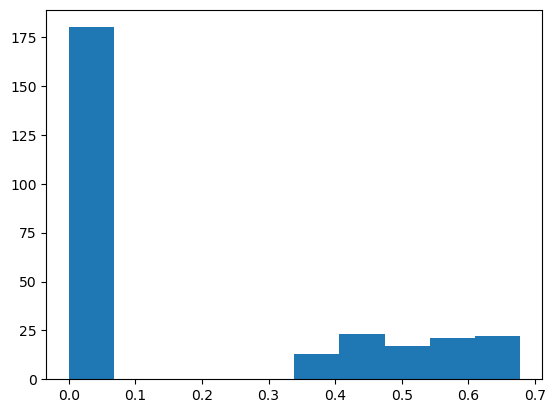

In [757]:
plt.hist(initial_merge['comb_fact'])

In [761]:
final_merge = pd.merge(initial_merge, malaria_sudan, how='left', left_on = 'year_x', right_on='DIM_TIME')

In [763]:
final_merge.head()

,ds,ndvi_value,year_x,month_x,ndvi_prob,ndvi_factor,ndwi_value,year_y,month_y,ndwi_prob,ndwi_factor,comb_fact,GEO_NAME_SHORT,DIM_TIME,Incidence_per_1000_people,outbreak
0,2000-01-16 00:00:00,0.235647,2000,1,0.861015,0.861015,-0.121937,2000,1,0.398798,0.398798,0.629907,Sudan,2000,92.77145,1
1,2000-02-15 00:00:00,0.244253,2000,2,0.892254,0.892254,-0.136662,2000,2,0.308931,0.308931,0.600593,Sudan,2000,92.77145,1
2,2000-03-16 00:00:00,0.260583,2000,3,0.951534,0.951534,-0.159775,2000,3,0.167875,0.167875,0.559705,Sudan,2000,92.77145,1
3,2000-04-15 12:00:00,0.273934,2000,4,1.000000,1.000000,-0.174150,2000,4,0.080147,0.080147,0.540074,Sudan,2000,92.77145,1
4,2000-05-16 00:00:00,0.229697,2000,5,0.839416,0.839416,-0.136522,2000,5,0.309783,0.309783,0.574600,Sudan,2000,92.77145,1


Now lets model the data using logarithmic regression

In [792]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [952]:
features = list(final_merge.columns[final_merge.columns != 'outbreak'])
features.remove('ds')
features.remove('GEO_NAME_SHORT')
features.remove('year_x')
features.remove('year_y')
features.remove('month_y')


X = final_merge[['ndvi_value','ndwi_value','month_x']]
y = final_merge['outbreak']

In [954]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = .2, stratify=y)

In [956]:
params = [{'solver':['liblinear','newton-cg'],'max_iter':[100, 200, 300, 500, 1000],'C':[100, 1000, 10000, 100000]}]

In [966]:
classifier = GridSearchCV(LogisticRegression(),
                      param_grid=params,
                      scoring='f1',
                      cv=5)

In [968]:
classifier.fit(Xtrain, ytrain)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [100, 1000, 10000, 100000],
                          'max_iter': [100, 200, 300, 500, 1000],
                          'solver': ['liblinear', 'newton-cg']}],
             scoring='f1')

In [980]:
accuracy_score(classifier.predict(Xtest), ytest)

0.6607142857142857

In [982]:
print("Classification Report for Test Data")
print(classification_report(ytest, classifier.predict(Xtest)))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.66      1.00      0.80        37
           1       0.00      0.00      0.00        19

    accuracy                           0.66        56
   macro avg       0.33      0.50      0.40        56
weighted avg       0.44      0.66      0.53        56



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
